In [1]:
!python --version
!date
!which python

Python 3.12.4
Sun Sep 29 14:36:18 CST 2024
/public/workspace/ryrl/venvs/versions/3.12.4/torch/bin/python


In [2]:
import os
import sys
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import networkx as nx
import torch.nn as nn

import matplotlib.pylab as plt

import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv, SuperGATConv


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torch_geometric.data import Data
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

sns.set_style(style='white')
# sns.set_theme(style=)

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.74 ms (started: 2024-10-01 15:18:42 +08:00)


In [3]:
adata = sc.read_h5ad('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/GEMXHumanPBMC.h5ad')
adata

AnnData object with n_obs × n_vars = 10237 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'scrublet'
    layers: 'counts'

time: 719 ms (started: 2024-10-01 15:18:44 +08:00)


In [3]:
# df = adata.to_df()
# coef = np.corrcoef(df, rowvar=True)
# coef.shape
# def normalization_for_NE(features_):
#     features = features_.copy()
#     for i in range(len(features)):
#         features[i] = features[i] / sum(features[i]) * 1000000
#     features = np.log2(features + 1)
#     return features
# @njit
# def NE_dn(w, N, eps):
#     w = w * N
#     D = np.sum(np.abs(w), axis=1) + eps
#     # D = 1 / D
#     # D = np.diag(D)
#     wn = np.dot(np.diag(1 / D), w)
#     return wn
# 
# # @njit
# def dominateset(aff_matrix, NR_OF_KNN):
#     thres = np.sort(aff_matrix)[:, -NR_OF_KNN]
#     
#     mask = aff_matrix >= thres[:, np.newaxis]
#     
#     # aff_matrix.T[aff_matrix.T < thres] = 0
#     aff_matrix = aff_matrix * mask
#     aff_matrix = (aff_matrix + aff_matrix.T) / 2
#     return aff_matrix
# 
# def TransitionFields(W, N, eps):
#     W = W * N
#     W = NE_dn(W, N, eps)
#     w = np.sqrt(np.sum(np.abs(W), axis=0) + eps)
#     W = W / np.expand_dims(w, 0).repeat(N, 0)
#     W = np.dot(W, W.T)
#     return W
# 
# def getNeMatrix(W_in):
#     N = len(W_in)
# 
#     K = min(20, N // 10)
#     alpha = 0.9
#     order = 3
#     eps = 1e-20
# 
#     W0 = W_in * (1 - np.eye(N))
#     W = NE_dn(W0, N, eps)
#     W = (W + W.T) / 2
# 
#     DD = np.sum(np.abs(W0), axis=0)
# 
#     P = (dominateset(np.abs(W), min(K, N - 1))) * np.sign(W)
#     P = P + np.eye(N) + np.diag(np.sum(np.abs(P.T), axis=0))
# 
#     P = TransitionFields(P, N, eps)
# 
#     D, U = np.linalg.eig(P)
#     d = D - eps
#     d = (1 - alpha) * d / (1 - alpha * d ** order)
#     D = np.diag(d)
#     W = np.dot(np.dot(U, D), U.T)
#     W = (W * (1 - np.eye(N))) / (1 - np.diag(W))
#     W = W.T
# 
#     D = np.diag(DD)
#     W = np.dot(D, W)
#     W[W < 0] = 0
#     W = (W + W.T) / 2
#     return W
# 
# 
# def getGraph(co_matrix, NE_matrix, L, K):
#     
#     sim_sh = 1.
#     for i in range(len(NE_matrix)):
#         NE_matrix[i][i] = sim_sh * max(NE_matrix[i])
#     
#     data = NE_matrix.reshape(-1)
#     data = np.sort(data)
#     data = data[:-int(len(data)*0.02)]
#     
#     min_sh = data[0]
#     max_sh = data[-1]
#     
#     delta = (max_sh - min_sh) / 100
# 
#     temp_cnt = []
#     for i in range(20):
#         s_sh = min_sh + delta * i
#         e_sh = s_sh + delta
#         temp_data = data[data > s_sh]
#         temp_data = temp_data[temp_data < e_sh]
#         temp_cnt.append([(s_sh + e_sh)/2, len(temp_data)])
#     
#     candi_sh = -1
#     for i in range(len(temp_cnt)):
#         pear_sh, pear_cnt = temp_cnt[i]
#         if 0 < i < len(temp_cnt) - 1:
#             if pear_cnt < temp_cnt[i+1][1] and pear_cnt < temp_cnt[i-1][1]:
#                 candi_sh = pear_sh
#                 break
#     if candi_sh < 0:
#         for i in range(1, len(temp_cnt)):
#             pear_sh, pear_cnt = temp_cnt[i]
#             if pear_cnt * 2 < temp_cnt[i-1][1]:
#                 candi_sh = pear_sh
#     if candi_sh == -1:
#         candi_sh = 0.3
#     
#     propor = len(NE_matrix[NE_matrix <= candi_sh])/(len(NE_matrix)**2)
#     propor = 1 - propor
#     thres = np.sort(NE_matrix)[:, -int(len(NE_matrix)*propor)]
#     co_matrix.T[NE_matrix.T <= thres] = 0
#             
#     # else:
#     #     return
# 
#     N = len(co_matrix)
#     
#     up_K = np.sort(co_matrix)[:,-K]
#     
#     mat_K = np.zeros(co_matrix.shape)
#     mat_K.T[co_matrix.T >= up_K] = 1
#     
#     thres_L = np.sort(co_matrix.flatten())[-int(((N*N)//(1 // (L+1e-8))))]
#     mat_K.T[co_matrix.T < thres_L] = 0
# 
#     return mat_K
# coef_ = getNeMatrix(coef)
# similarty_matrix = pd.read_csv('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/GEMXHumanPBMC_NE_Matrix.parquet', index_col=0)
# coef_ = similarty_matrix.values
# similarty_matrix.head()
# pd.DataFrame(coef_, columns=df.index, index=df.index).to_csv('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/GEMXHumanPBMC_NE_Matrix.parquet')
# similarty_matrix = pd.DataFrame(coef_, columns=df.index, index=df.index)
# similarty_matrix.head()
# N = len(similarty_matrix)
# avg_N = N // 20
# K = avg_N // 10
# K = min(K, 20)
# K = max(K, 6)

# graph = getGraph(co_matrix=coef, NE_matrix=coef_, L=0, K=6)


# G = nx.from_pandas_adjacency(demo_)
# nx.number_connected_components(G)
# import matplotlib.pylab as plt
# pos = nx.spring_layout(G)
# nx.draw(G, pos, node_size=50, with_labels=False)
# plt.show()

(10237, 10237)

time: 11 s (started: 2024-09-30 11:00:23 +08:00)


In [4]:
similarty = cosine_similarity(adata.to_df())

time: 7.26 s (started: 2024-10-01 15:19:01 +08:00)


In [5]:
K = 10
indices = np.argsort(-similarty, axis=1)[:, 1:K+1]
adjacency_matrix = np.zeros_like(similarty)
adjacency_matrix[np.arange(similarty.shape[0])[:, np.newaxis], indices] = 1

time: 2.64 s (started: 2024-10-01 15:19:09 +08:00)


In [14]:
edge_index = np.array(np.nonzero(adjacency_matrix))
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_weight = similarty[edge_index[0], edge_index[1]]

time: 883 ms (started: 2024-09-30 14:24:29 +08:00)


In [15]:
X = torch.tensor(adata.to_df().values)
edge_weight = torch.tensor(edge_weight, dtype=torch.float)
data = Data(x=X, edge_index=edge_index, edge_weight=edge_weight)

time: 1.32 s (started: 2024-09-30 14:25:13 +08:00)


In [17]:
# torch.save(obj=data, f='/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/Graph.pt')

time: 4 s (started: 2024-09-30 14:43:39 +08:00)


# <font color='#FFDC91FF'>Graph Cluster</font>

In [8]:
data = torch.load('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/Graph.pt')
data

/tmp/ipykernel_5413/1033191681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/Graph.p

Data(x=[10237, 38606], edge_index=[2, 102370], edge_weight=[102370])

time: 1.05 s (started: 2024-10-01 15:19:59 +08:00)


In [11]:
class GATAutoEncoder(nn.Module):
    
    def __init__(self, in_channel: int = 38606, hidden_channel: int = 512, embedding_dim: int = 1024, num_heads: int = 8):
        super().__init__()
        self.encoder = GATConv(in_channels=in_channel, out_channels=hidden_channel, heads=num_heads, concat=True)
        self.embedding = nn.Linear(in_features=hidden_channel * num_heads, out_features=embedding_dim)
        self.decoder = nn.Linear(in_features=embedding_dim, out_features=in_channel)
    
    def forward(self, x, edge_index, edge_weight):
        x = self.encoder(x, edge_index, edge_weight)
        x = F.relu(x)
        z = self.embedding(x)
        x = self.decoder(z)
        return x, z

time: 1.19 ms (started: 2024-10-01 15:20:16 +08:00)


In [18]:
model = GATAutoEncoder(embedding_dim=1024)
optimizer = torch.optim.Adam(params=model.parameters(), lr=.001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

time: 2.51 s (started: 2024-10-01 15:51:18 +08:00)


In [19]:
num_epochs = 500
lst = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    x, z = model(x=data.x, edge_index=data.edge_index, edge_weight=data.edge_weight)
    loss = loss_fn(x, data.x)
    loss.backward()
    optimizer.step()
    
    lst.append((epoch, loss))
    if epoch % 10 == 0:
        print(f'Epoch: {epoch + 1}, Loss: {loss.item(): .4f}')

Epoch: 1, Loss:  0.1882
Epoch: 11, Loss:  0.1791
Epoch: 21, Loss:  0.1642
Epoch: 31, Loss:  0.1587
Epoch: 41, Loss:  0.1422
Epoch: 51, Loss:  0.0907
Epoch: 61, Loss:  0.0687
Epoch: 71, Loss:  0.0634
Epoch: 81, Loss:  0.0614
Epoch: 91, Loss:  0.0606
Epoch: 101, Loss:  0.0600
Epoch: 111, Loss:  0.0583
Epoch: 121, Loss:  0.0545
Epoch: 131, Loss:  0.0532
Epoch: 141, Loss:  0.0531
Epoch: 151, Loss:  0.0529
Epoch: 161, Loss:  0.0529
Epoch: 171, Loss:  0.0528
Epoch: 181, Loss:  0.0528
Epoch: 191, Loss:  0.0528
Epoch: 201, Loss:  0.0529
Epoch: 211, Loss:  0.0528
Epoch: 221, Loss:  0.0528
Epoch: 231, Loss:  0.0528
Epoch: 241, Loss:  0.0528
Epoch: 251, Loss:  0.0528
Epoch: 261, Loss:  0.0528
Epoch: 271, Loss:  0.0527
Epoch: 281, Loss:  0.0527
Epoch: 291, Loss:  0.0525
Epoch: 301, Loss:  0.0521
Epoch: 311, Loss:  0.0518
Epoch: 321, Loss:  0.0513
Epoch: 331, Loss:  0.0514
Epoch: 341, Loss:  0.0512
Epoch: 351, Loss:  0.0511
Epoch: 361, Loss:  0.0511
Epoch: 371, Loss:  0.0511
Epoch: 381, Loss:  0.05

<Axes: xlabel='Epoch', ylabel='Loss'>

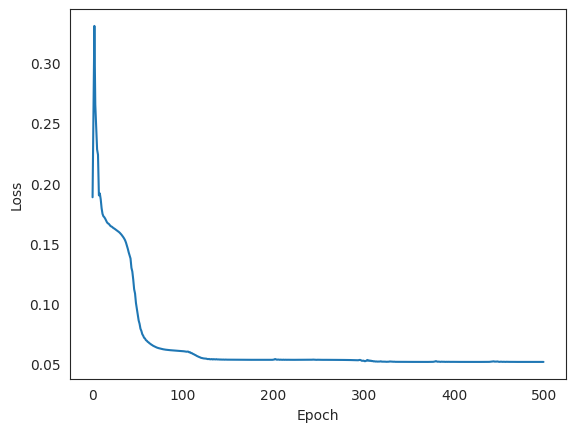

time: 194 ms (started: 2024-10-01 17:02:33 +08:00)


In [20]:
df = pd.DataFrame(lst, columns=['Epoch', 'Loss'])
df = df.assign(Loss=df['Loss'].apply(lambda x: x.item()))
# df.head()
sns.lineplot(data=df.drop(index=1), x='Epoch', y='Loss')

In [21]:
model.eval()
with torch.no_grad():
    _, embeddings = model(data.x, data.edge_index, edge_weight=data.edge_weight)
    embeddings = embeddings.cpu().numpy()

time: 3.73 s (started: 2024-10-01 17:02:37 +08:00)


In [22]:
# 聚类
num_clusters = 13  # 根据您的数据情况调整
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(embeddings) 

time: 465 ms (started: 2024-10-01 17:03:13 +08:00)


Text(0, 0.5, 'Dimension 2')

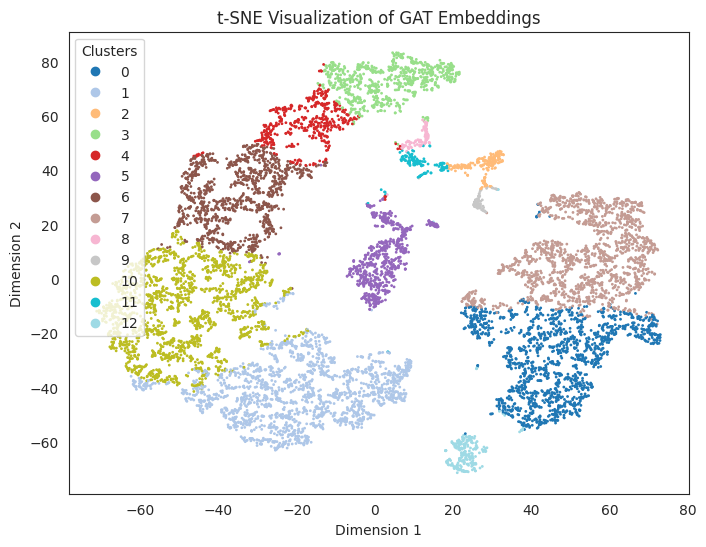

time: 1min 37s (started: 2024-10-01 17:03:17 +08:00)


In [23]:
# 可视化
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab20', s=1)
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.title('t-SNE Visualization of GAT Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

In [ ]:
import anndata

adata_ = anndata.AnnData(embeddings)

In [38]:
sc.pp.neighbors(adata_, n_neighbors=15, use_rep='X')
# adata_

time: 17.4 s (started: 2024-10-01 17:41:15 +08:00)


In [40]:
sc.tl.tsne(adata_, n_pcs=2, random_state=0, perplexity=50)
sc.tl.leiden(adata_, flavor='igraph', resolution=.2)

/public/workspace/ryrl/venvs/versions/3.12.4/torch/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 256 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


time: 1min 34s (started: 2024-10-01 17:43:19 +08:00)


In [41]:
adata_

AnnData object with n_obs × n_vars = 10237 × 256
    obs: 'leiden'
    uns: 'neighbors', 'leiden', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

time: 2.85 ms (started: 2024-10-01 17:46:03 +08:00)


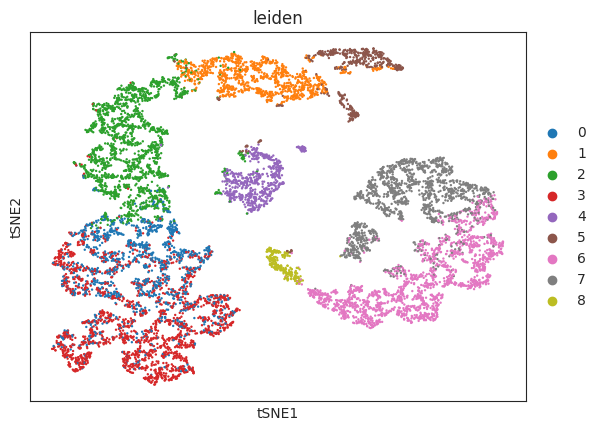

time: 310 ms (started: 2024-10-01 17:46:55 +08:00)


In [45]:
sc.pl.tsne(adata_, color='leiden')

In [46]:
adata_

AnnData object with n_obs × n_vars = 10237 × 256
    obs: 'leiden'
    uns: 'neighbors', 'leiden', 'pca', 'tsne', 'leiden_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

time: 1.83 ms (started: 2024-10-01 19:16:45 +08:00)


In [69]:
adata_.obsp['connectivities'].toarray()

False

time: 328 ms (started: 2024-10-01 19:20:36 +08:00)


In [72]:
adata_.obsm['X_tsne']

array([[-33.698505, -36.80475 ],
       [ 14.440226,  63.932217],
       [-39.40404 ,  13.62542 ],
       ...,
       [-64.09336 , -65.42827 ],
       [-42.037773, -40.09353 ],
       [ 32.414215, -37.924   ]], dtype=float32)

time: 2.37 ms (started: 2024-10-01 19:23:37 +08:00)
